In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors, topological_category_labels_latex
from src.signal_categories import physics_category_labels, physics_category_colors
from src.signal_categories import filetype_category_labels, filetype_category_colors

from src.file_locations import intermediate_files_location


# File Loading

In [2]:
training = "first_combined_training"
#training = "first_wc_training"
#training = "first_lantern_training"

#training = "first_combined_physics_training"


In [3]:
print("loading all_df.pkl...")
with open(f"{intermediate_files_location}/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
print("loading predictions.pkl...")
with open(f"../training_outputs/{training}/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

print("merging all_df and predictions.pkl...")
merged_df = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")

sig_categories = topological_category_labels
sig_category_labels_latex = topological_category_labels_latex

if "physics" in training:
    sig_categories = physics_category_labels
    sig_category_labels_latex = physics_category_labels

prob_categories = ["prob_" + cat for cat in sig_categories]

for prob in prob_categories:
    merged_df[prob] = merged_df[prob].fillna(-1)

num_train_events = len(merged_df.query("used_for_training == True"))
num_test_events = len(merged_df.query("used_for_testing == True"))
frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")

modified_net_weights = []
used_for_testing = merged_df["used_for_testing"].to_numpy()
wc_net_weights = merged_df["wc_net_weight"].to_numpy()
for i in range(len(merged_df)):
    if used_for_testing[i]:
        modified_net_weights.append(wc_net_weights[i] / frac_test)
    else:
        modified_net_weights.append(wc_net_weights[i])
merged_df["wc_net_weight"] = modified_net_weights         

merged_df = merged_df.query("used_for_testing == True")


loading all_df.pkl...
all_df.shape=(2171921, 210)
loading predictions.pkl...
pred_df.shape=(356805, 22)
merging all_df and predictions.pkl...
weighting up by the fraction of test events: 0.500


In [4]:
print(f"{merged_df.shape=}")
presel_merged_df = merged_df.query("wc_kine_reco_Enu > 0 and wc_shw_sp_n_20mev_showers > 0")
print(f"{presel_merged_df.shape=}")

presel_merged_df


merged_df.shape=(178403, 228)
presel_merged_df.shape=(178403, 228)


,wc_match_isFC,wc_single_photon_ncpi0_score,wc_numu_score,wc_single_photon_nue_score,wc_single_photon_other_score,wc_nc_pio_score,wc_single_photon_numu_score,wc_nue_score,wc_kine_reco_Enu,wc_shw_sp_n_20mev_showers,...,prob_2g0p,prob_2gNp1mu,prob_2g0p1mu,prob_2g_outFV,prob_1eNp,prob_1e0p,prob_0g,prob_3plusg,prob_dirt,prob_ext
7,True,0.272143,-1.043858,-1.676819,-2.556328,-1.320506,-2.101542,-15.000000,72.947304,1.0,...,0.003184,0.000547,0.000398,0.000977,0.000051,0.000005,0.242148,0.000317,0.090412,0.631925
21,True,-0.462797,-0.710490,-1.911803,-1.135650,-3.169012,-1.800440,-4.049474,263.214722,2.0,...,0.002867,0.003349,0.000513,0.000577,0.000205,0.000040,0.812107,0.000224,0.015758,0.154273
60,False,0.284562,3.305738,-2.338027,-0.412643,-2.242356,-3.624760,-12.973451,976.803040,2.0,...,0.000246,0.029301,0.006420,0.000166,0.000128,0.000006,0.955914,0.002136,0.000026,0.001119
71,True,0.458589,1.362073,-2.933243,-1.075697,-3.127084,-2.554086,-9.857704,805.092773,1.0,...,0.001476,0.095064,0.004417,0.000335,0.000779,0.000038,0.848858,0.001380,0.000373,0.003966
83,False,0.529745,0.210693,-0.845269,-3.781686,-3.721158,-4.104197,-9.418540,123.078445,1.0,...,0.000506,0.000278,0.000500,0.000212,0.000032,0.000023,0.960382,0.000092,0.000896,0.031190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2171909,True,-1.025371,0.011210,0.115422,-0.876827,2.423527,-0.692325,-15.000000,583.533447,1.0,...,0.082601,0.125542,0.013836,0.004769,0.000059,0.000018,0.000504,0.010099,0.001078,0.014088
2171910,True,0.632392,2.189116,0.403370,1.868630,-1.537735,-2.520487,-15.000000,2034.660156,1.0,...,0.008662,0.783315,0.030073,0.000353,0.000052,0.000032,0.000626,0.084489,0.000184,0.001101
2171916,True,-1.324178,-0.144581,0.965156,1.262726,2.330691,-0.237735,-9.097902,990.763000,4.0,...,0.367651,0.067337,0.023865,0.008723,0.000246,0.000082,0.007103,0.182235,0.000372,0.092119
2171917,True,0.316977,-0.760487,0.088589,-1.296508,1.098346,1.388392,-15.000000,367.168182,1.0,...,0.012527,0.010682,0.001667,0.001561,0.000040,0.000007,0.764642,0.000430,0.047104,0.112612


In [5]:
probs_2d_arr = presel_merged_df[prob_categories].to_numpy()
reco_categories_argmax = np.argmax(probs_2d_arr, axis=1)
presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax

reco_category_queries = []
for i, signal_category in enumerate(sig_categories):
    reco_category_queries.append(f"reco_category_argmax_index == {i}")


# Multi-Class Histograms

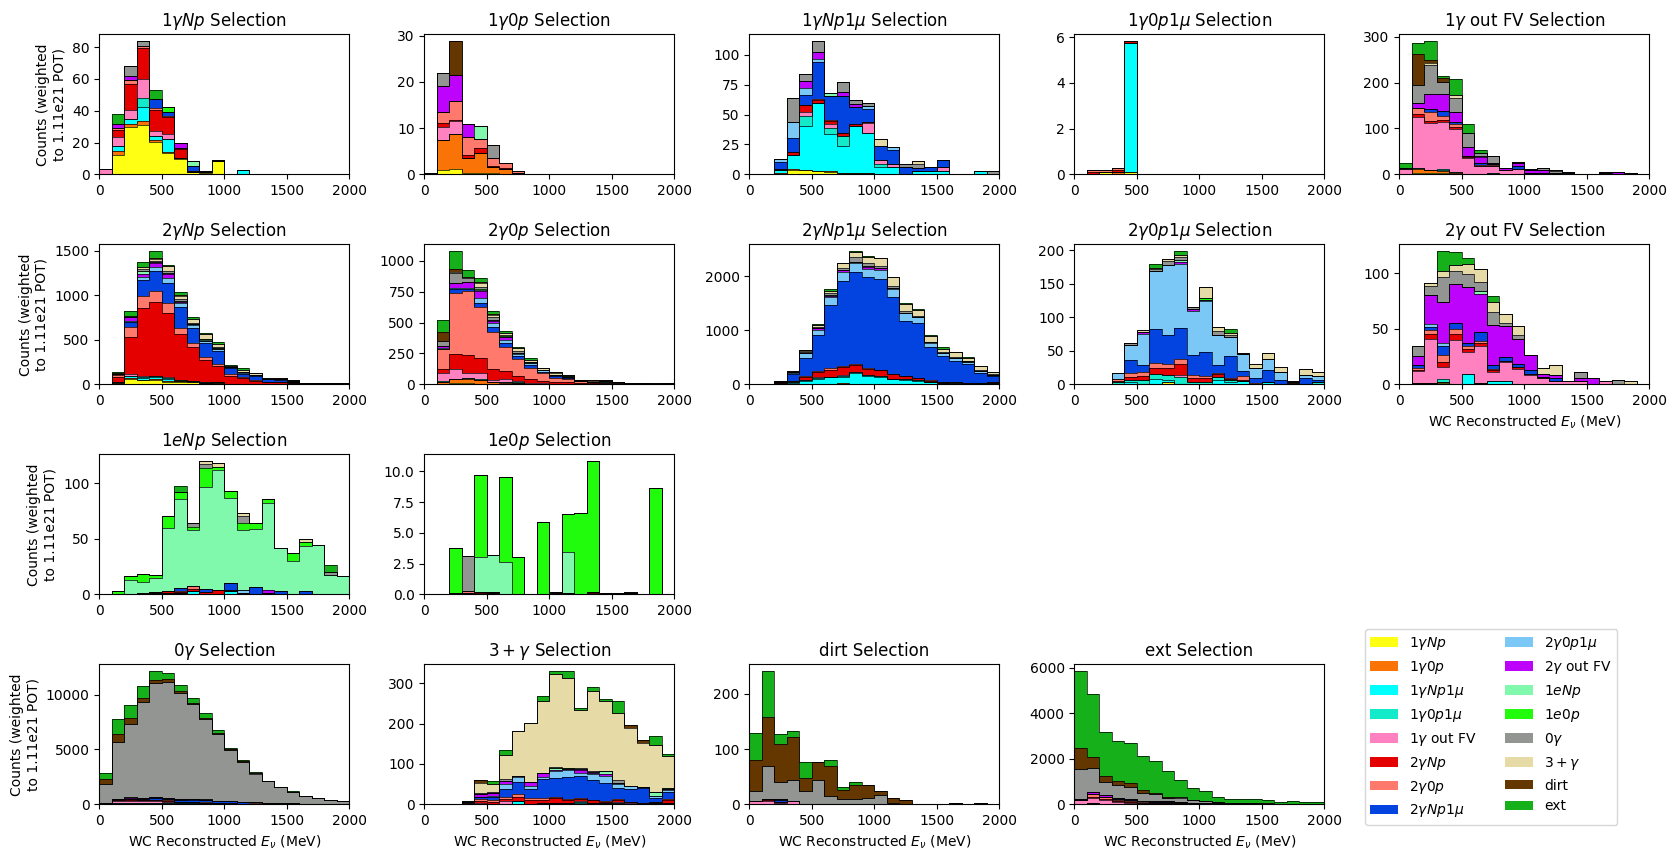

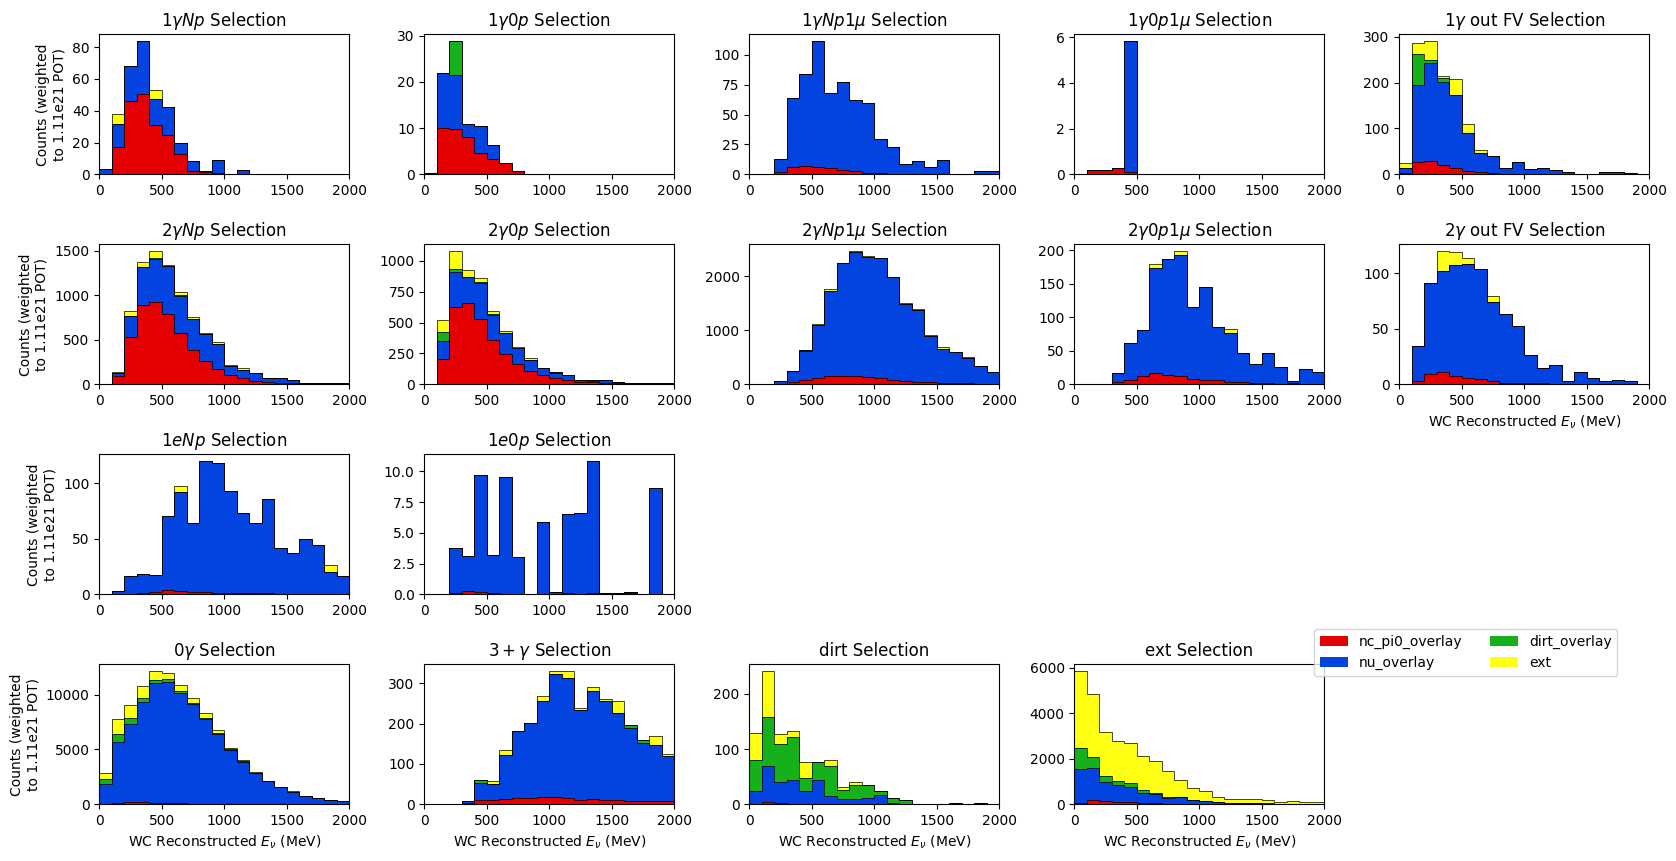

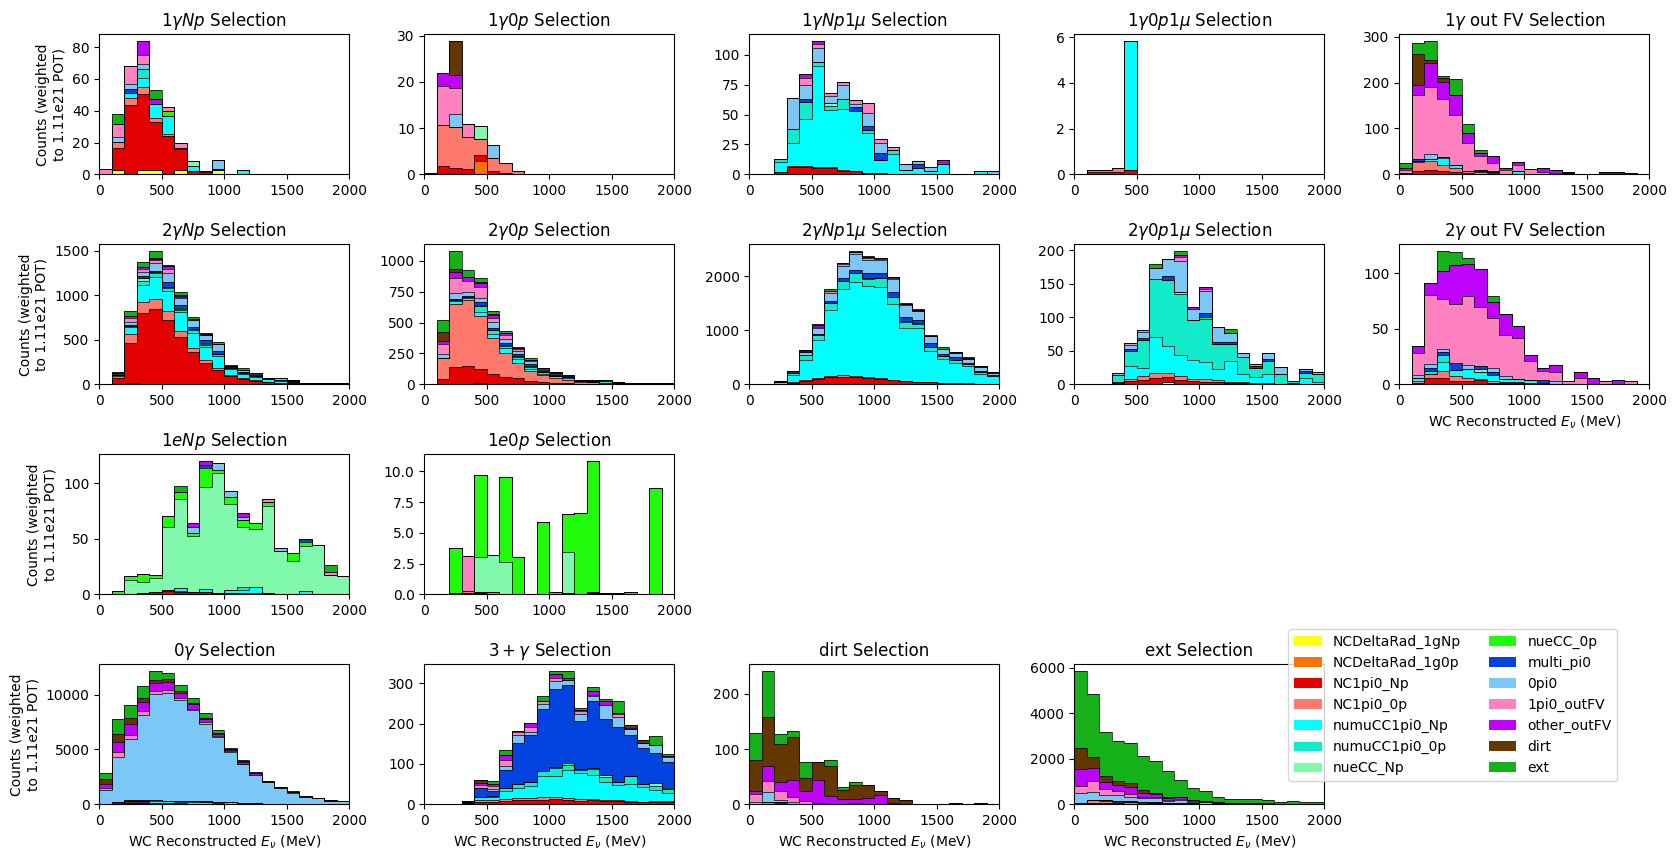

In [6]:
for breakdown_type in ["topological", "filetype", "physics"]:
    if breakdown_type == "topological":
        breakdown_labels = topological_category_labels
        breakdown_labels_latex = topological_category_labels_latex
        breakdown_colors = topological_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"topological_signal_category == '{label}'")
    elif breakdown_type == "physics":
        breakdown_labels = physics_category_labels
        breakdown_labels_latex = physics_category_labels
        breakdown_colors = physics_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"physics_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_labels_latex = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")

    fig, axs = plt.subplots(4, 5, figsize=(20, 10))
    axs = axs.flatten()

    bins = np.linspace(0, 2000, 21)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    multi_bin_centers = [bin_centers] * len(breakdown_labels)
    outline_colors = ["k"] * len(breakdown_labels)

    for i in range(len(sig_categories)):

        signal_category = sig_categories[i]
        signal_category_latex = sig_category_labels_latex[i]

        sel_df = presel_merged_df.query(reco_category_queries[i])

        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], weights=curr_df["wc_net_weight"], bins=bins)[0])

        axnum = i
        if i >= 12: # background categories, start new row
            axnum = i + 3

        axs[axnum].hist(multi_bin_centers, weights=counts, bins=bins, color=breakdown_colors, stacked=True, label=breakdown_labels_latex)
        axs[axnum].hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)

        
        if axnum in [15, 16, 17, 18, 9]:
            axs[axnum].set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
        if axnum % 5 == 0: # Only show y-label for leftmost column
            axs[axnum].set_ylabel("Counts (weighted\nto 1.11e21 POT)")
        axs[axnum].set_title(f"{signal_category_latex} Selection")
        axs[axnum].set_xlim(0, 2000)

        if axnum == 18:
            axs[axnum].legend(ncol=2, loc='upper right', bbox_to_anchor=(2.2, 1.3))
    
    for axnum in range(20):
        if axnum in [12, 13, 14, 19]:
            axs[axnum].remove()

    fig.subplots_adjust(hspace=0.5, wspace=0.3)

    plt.savefig(f"../plots/multiclass_histograms_{training}_{breakdown_type}.pdf")
    plt.savefig(f"../plots/multiclass_histograms_{training}_{breakdown_type}.png")


# Checking Event Weights

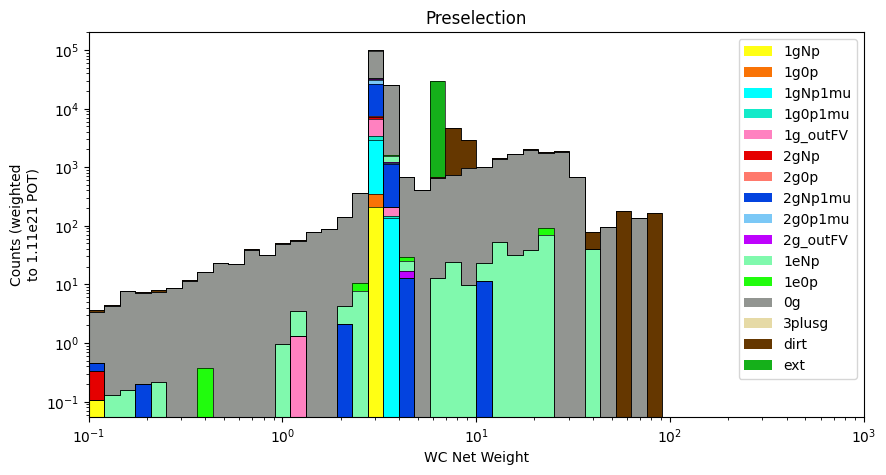

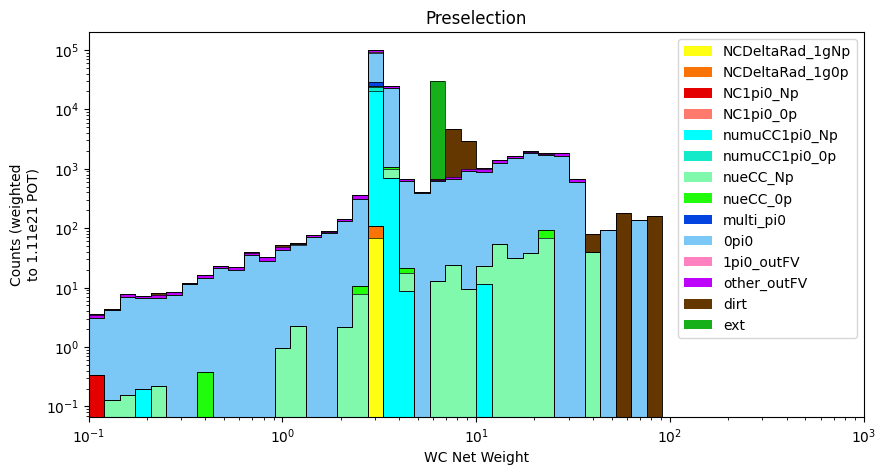

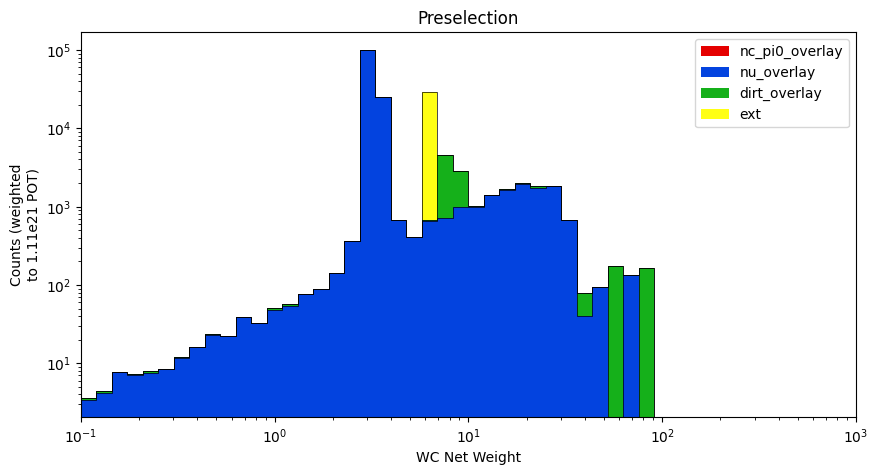

In [7]:
for breakdown_type in ["topological", "physics", "filetype"]:
    if breakdown_type == "topological":
        breakdown_labels = topological_category_labels
        breakdown_colors = topological_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"topological_signal_category == '{label}'")
    elif breakdown_type == "physics":
        breakdown_labels = physics_category_labels
        breakdown_colors = physics_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"physics_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")

    plt.figure(figsize=(10, 5))

    bins = np.logspace(-1, 3, 51)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    multi_bin_centers = [bin_centers] * len(breakdown_labels)
    outline_colors = ["k"] * len(breakdown_labels)

    sel_df = presel_merged_df
    counts = []
    for breakdown_i, breakdown_label in enumerate(breakdown_labels):
        curr_df = sel_df.query(breakdown_queries[breakdown_i])
        counts.append(np.histogram(curr_df["wc_net_weight"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])

    plt.hist(multi_bin_centers, weights=counts, bins=bins, color=breakdown_colors, stacked=True, label=breakdown_labels)
    plt.hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)

    plt.xlabel(r"WC Net Weight")
    plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
    plt.xlim(bins[0], bins[-1])
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(loc="upper right")
    plt.title("Preselection")
    plt.show()



# Post-Selection Studies

In [8]:
one_g_reco_category_argmax_indices = []
for i, signal_category in enumerate(sig_categories):
    if "1g" in signal_category:
        one_g_reco_category_argmax_indices.append(i)

combined_1g_query = ""
for i in one_g_reco_category_argmax_indices:
    combined_1g_query += f"reco_category_argmax_index == {i} or "
combined_1g_query = combined_1g_query[:-4]

all_1g_sel_df = presel_merged_df.query(combined_1g_query)

print(f"{presel_merged_df.shape=}")
print(f"{all_1g_sel_df.shape=}")

presel_merged_df.shape=(178403, 229)
all_1g_sel_df.shape=(4621, 229)


## Blip Veto

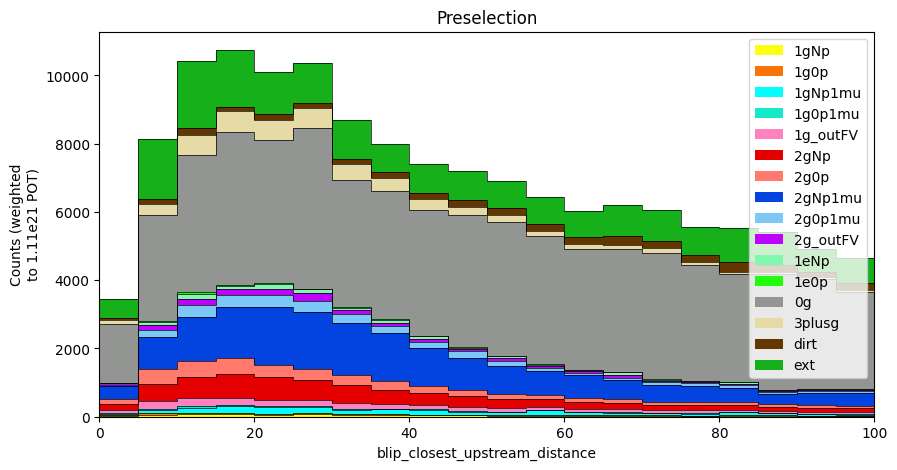

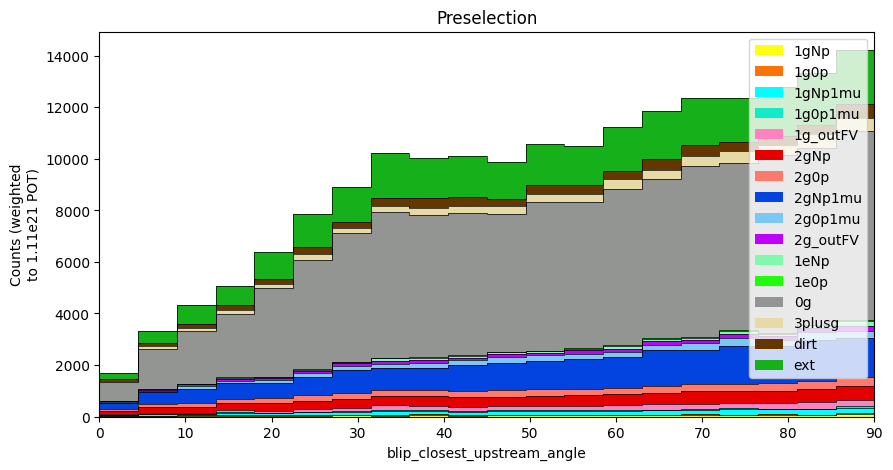

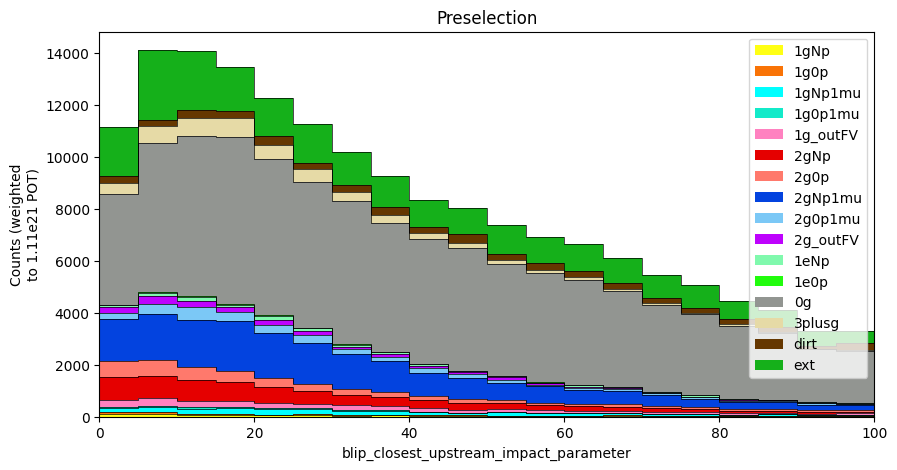

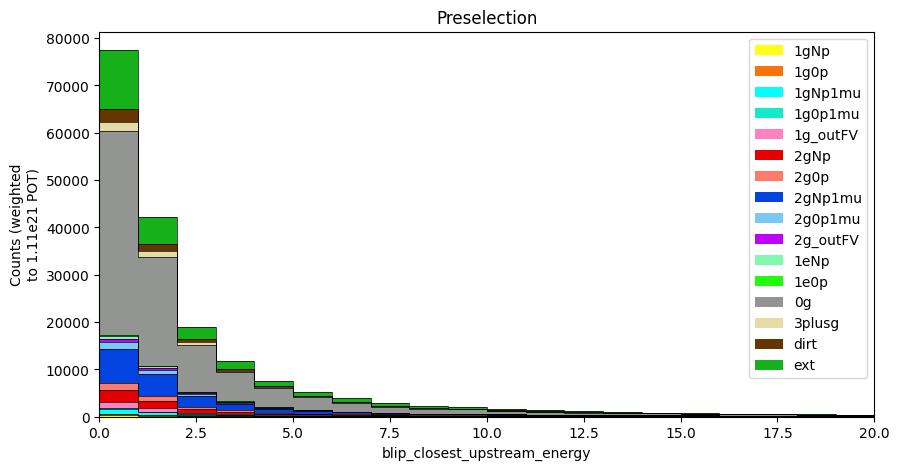

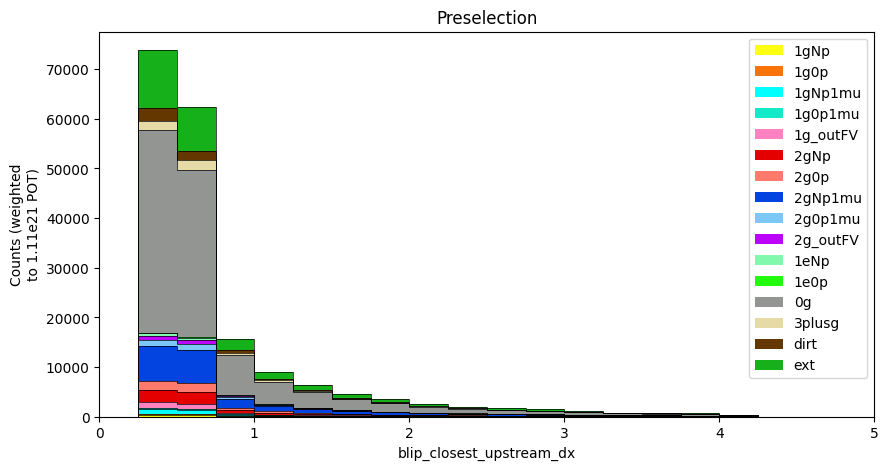

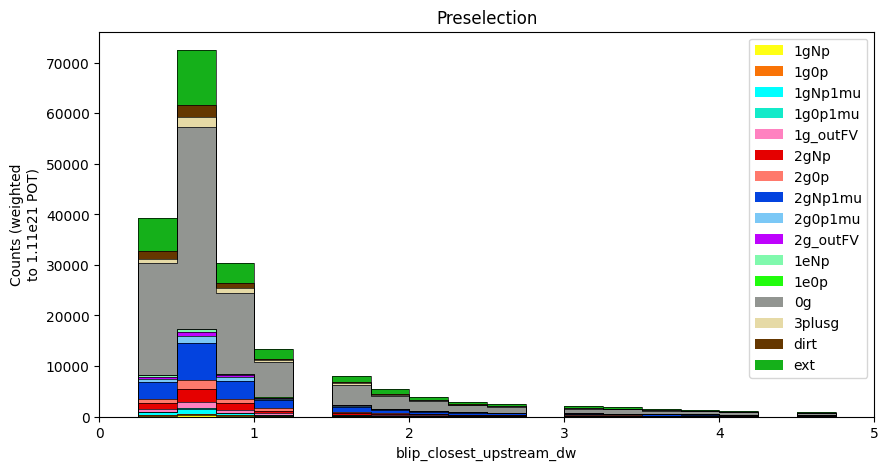

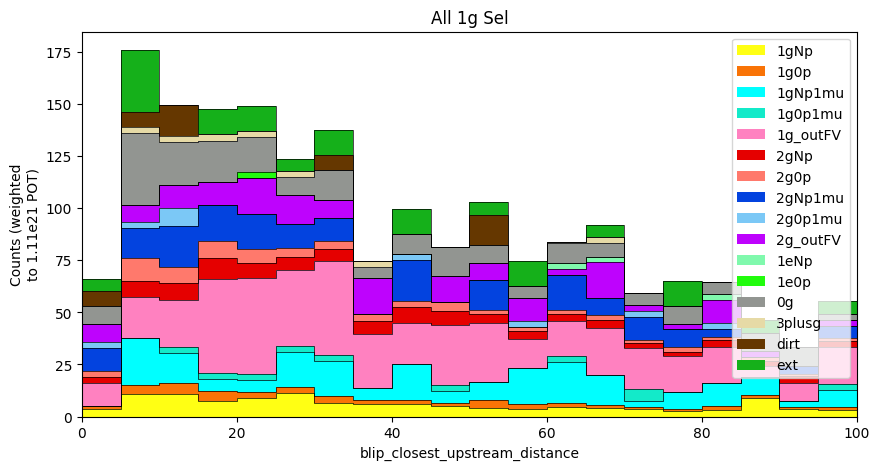

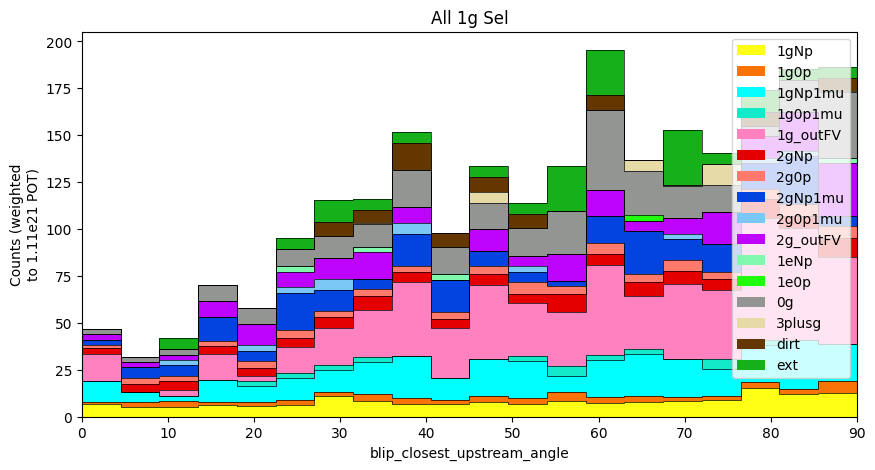

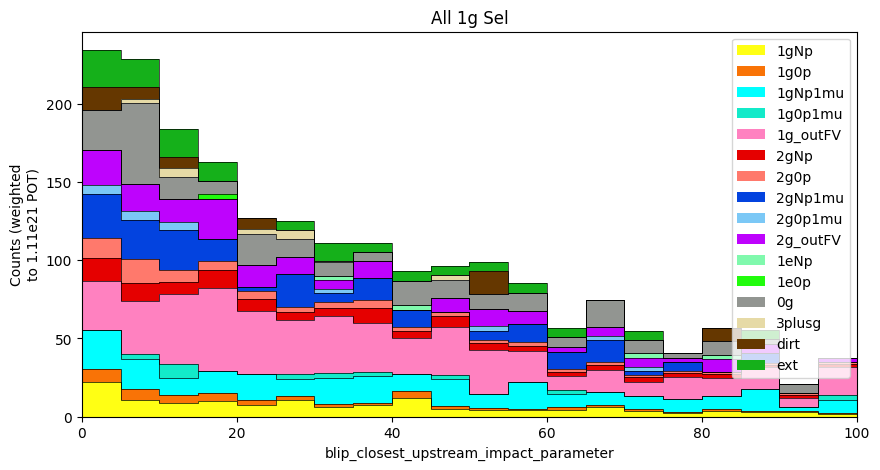

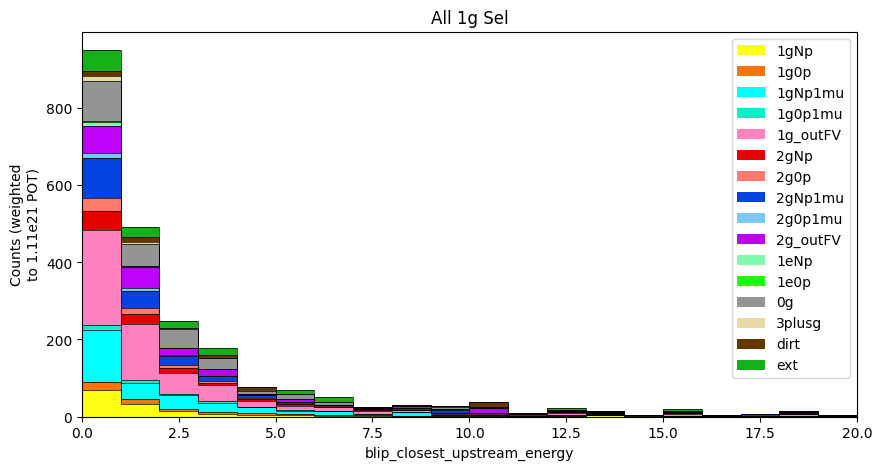

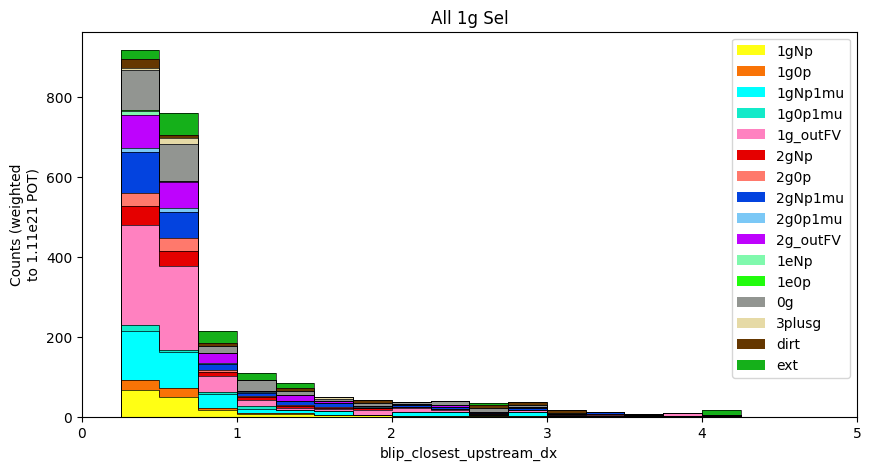

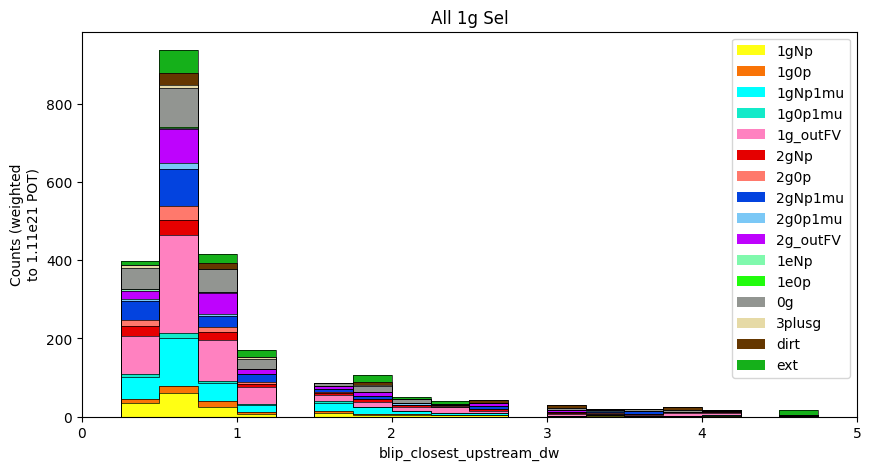

In [9]:
for breakdown_type in ["topological"]:
    if breakdown_type == "topological":
        breakdown_labels = topological_category_labels
        breakdown_colors = topological_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"topological_signal_category == '{label}'")
    elif breakdown_type == "physics":
        breakdown_labels = physics_category_labels
        breakdown_colors = physics_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"physics_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")
    
    for sel_type in ["presel", "all_1g"]:
        if sel_type == "presel":
            sel_df = presel_merged_df
        elif sel_type == "all_1g":
            sel_df = all_1g_sel_df
                
        blip_postprocessing_vars_bin_ranges = [
            ("blip_closest_upstream_distance", 0, 100),
            ("blip_closest_upstream_angle", 0, 90),
            ("blip_closest_upstream_impact_parameter", 0, 100),
            ("blip_closest_upstream_energy", 0, 20),
            ("blip_closest_upstream_dx", 0, 5),
            ("blip_closest_upstream_dw", 0, 5),
        ]

        for var, min_val, max_val in blip_postprocessing_vars_bin_ranges:

            plt.figure(figsize=(10, 5))
            bins = np.linspace(min_val, max_val, 21)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            multi_bin_centers = [bin_centers] * len(breakdown_labels)
            outline_colors = ["k"] * len(breakdown_labels)
            counts = []
            for breakdown_i, breakdown_label in enumerate(breakdown_labels):
                curr_df = sel_df.query(breakdown_queries[breakdown_i])
                counts.append(np.histogram(curr_df[var].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])
            plt.hist(multi_bin_centers, weights=counts, bins=bins, color=breakdown_colors, stacked=True, label=breakdown_labels)
            plt.hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)
            plt.xlabel(var)
            plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
            plt.xlim(bins[0], bins[-1])
            plt.legend(loc="upper right")
            if sel_type == "presel":
                plt.title(f"Preselection")
            else:
                plt.title(f"All 1g Sel")
            plt.show()


## Nanosecond Timing

In [10]:
# related to https://github.com/brb-rightback/ns_demo_MCC9.10/blob/main/ns_demo_MCC9.10.ipynb
# TODO: Validate this with data and showers, see https://microboone-docdb.fnal.gov/cgi-bin/sso/ShowDocument?docid=44781
# Also check the manually applied shifts for all the different time periods

data_presel_merged_df = presel_merged_df.query("filetype == 'data' or filetype == 'ext'")
mc_presel_merged_df = presel_merged_df.query("not (filetype == 'data' or filetype == 'ext')")

data_presel_merged_df["non_merge_time"] = data_presel_merged_df["wc_evtTimeNS"]
mc_presel_merged_df["non_merge_time"] = mc_presel_merged_df["wc_evtTimeNS_cor"] + 1500 # manually shifting MC to approximately match data

run = data_presel_merged_df["run"].to_numpy()
evtTimeNS = data_presel_merged_df["wc_evtTimeNS"].to_numpy()
new_times = []
for i in range(len(evtTimeNS)):
    gap=18.936
    Shift=0
    TThelp=0
    if (run[i] >= 19500): Shift=2920.5 
    elif (run[i] >= 17380): Shift=2916.0 
    elif (run[i] >= 13697): Shift = 3147.3
    elif (run[i] >= 10812): Shift = 3568.5 
    elif (run[i] >= 8321): Shift = 3610.7
    elif (run[i] >= 5800): Shift = 3164.4
    elif (run[i] > 0 ): Shift = 3168.9
    TThelp = evtTimeNS[i]-Shift+gap*0.5
    if np.isinf(TThelp):
        TThelp = np.nan
    TT_merged = -9999.
    if(TThelp>=0): 
        TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
    new_times.append(TT_merged)
data_presel_merged_df["merge_time"] = new_times

evtTimeNS = mc_presel_merged_df["wc_evtTimeNS_cor"].to_numpy()
new_times = []
for i in range(len(evtTimeNS)):
    gap=18.936
    Shift=5.8-0.3
    TThelp=0
    TThelp = np.nan_to_num(evtTimeNS[i]-Shift+gap*0.5,nan=-9999)
    TT_merged = -9999.
    if(TThelp>=0):
        TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
    new_times.append(TT_merged)
mc_presel_merged_df["merge_time"] = new_times

presel_merged_df = pd.concat([data_presel_merged_df, mc_presel_merged_df])
all_1g_sel_df = presel_merged_df.query(combined_1g_query)


/tmp/ipykernel_2802488/889027030.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_presel_merged_df["non_merge_time"] = data_presel_merged_df["wc_evtTimeNS"]
/tmp/ipykernel_2802488/889027030.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_presel_merged_df["non_merge_time"] = mc_presel_merged_df["wc_evtTimeNS_cor"] + 1500 # manually shifting MC to approximately match data
/tmp/ipykernel_2802488/889027030.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

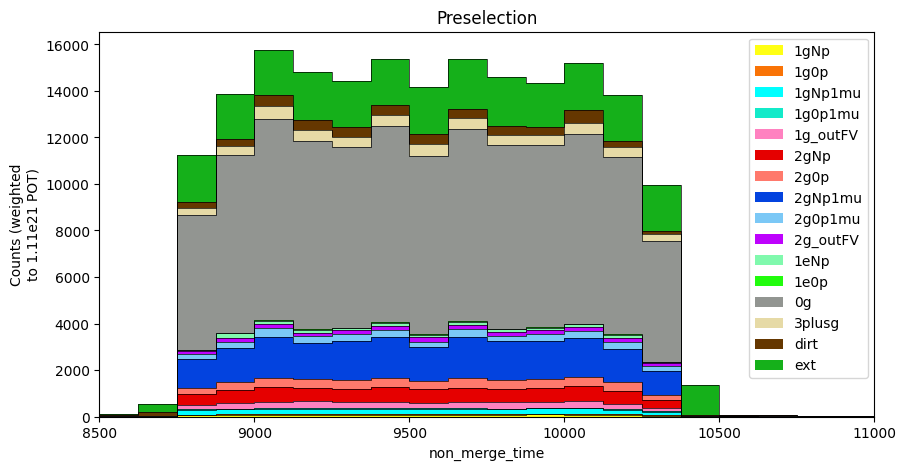

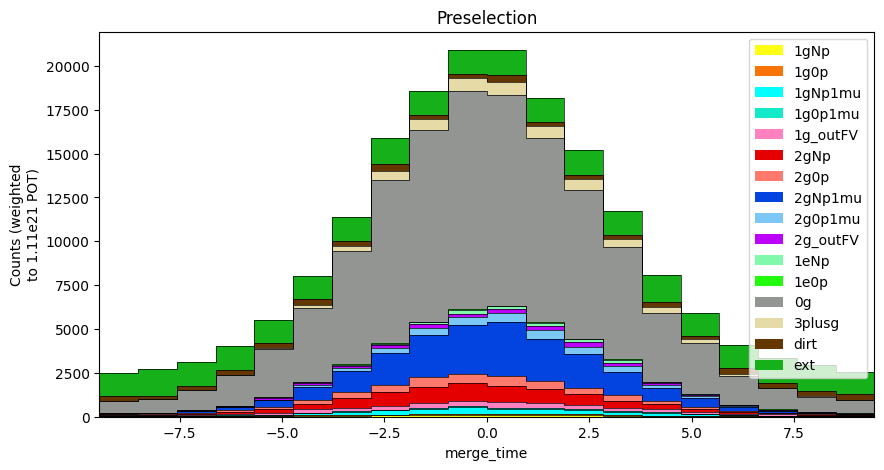

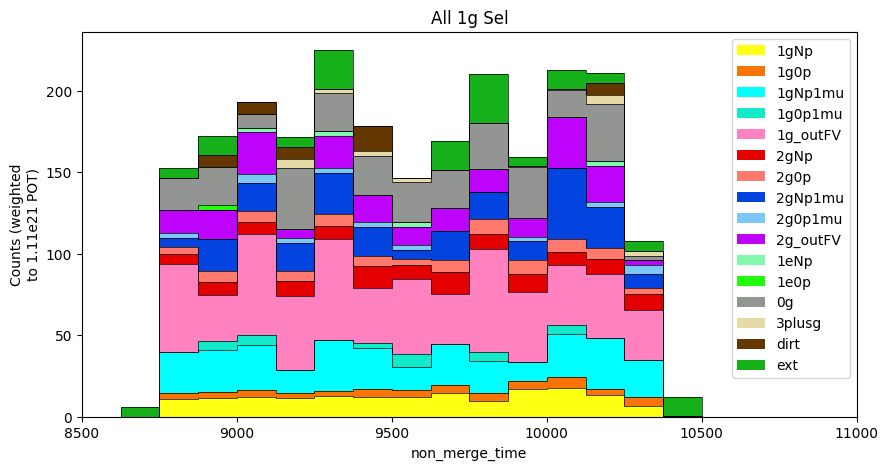

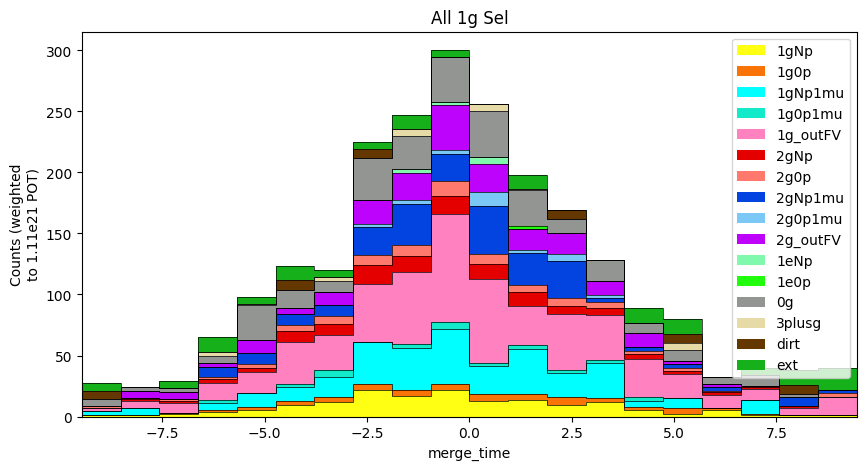

In [11]:
for breakdown_type in ["topological"]:
    if breakdown_type == "topological":
        breakdown_labels = topological_category_labels
        breakdown_colors = topological_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"topological_signal_category == '{label}'")
    elif breakdown_type == "physics":
        breakdown_labels = physics_category_labels
        breakdown_colors = physics_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"physics_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")
    
    for sel_type in ["presel", "all_1g"]:
        if sel_type == "presel":
            sel_df = presel_merged_df
        elif sel_type == "all_1g":
            sel_df = all_1g_sel_df


        plt.figure(figsize=(10, 5))
        bins = np.linspace(8500, 11000, 21)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        multi_bin_centers = [bin_centers] * len(breakdown_labels)
        outline_colors = ["k"] * len(breakdown_labels)
        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            counts.append(np.histogram(curr_df["non_merge_time"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])
        plt.hist(multi_bin_centers, weights=counts, bins=bins, color=breakdown_colors, stacked=True, label=breakdown_labels)
        plt.hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)
        plt.xlabel("non_merge_time")
        plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
        plt.xlim(bins[0], bins[-1])
        plt.legend(loc="upper right")
        if sel_type == "presel":
            plt.title(f"Preselection")
        else:
            plt.title(f"All 1g Sel")
        plt.show()


        plt.figure(figsize=(10, 5))
        bins = np.linspace(-9.462531250000058, 9.462531250000058, 21)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        multi_bin_centers = [bin_centers] * len(breakdown_labels)
        outline_colors = ["k"] * len(breakdown_labels)
        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            counts.append(np.histogram(curr_df["merge_time"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])
        plt.hist(multi_bin_centers, weights=counts, bins=bins, color=breakdown_colors, stacked=True, label=breakdown_labels)
        plt.hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)
        plt.xlabel("merge_time")
        plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
        plt.xlim(bins[0], bins[-1])
        plt.legend(loc="upper right")
        if sel_type == "presel":
            plt.title(f"Preselection")
        else:
            plt.title(f"All 1g Sel")
        plt.show()


## Out-TPC PMT Veto

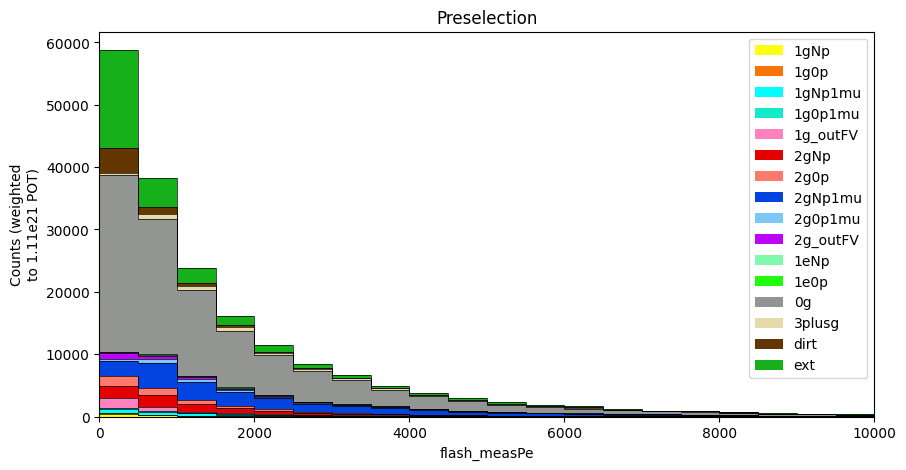

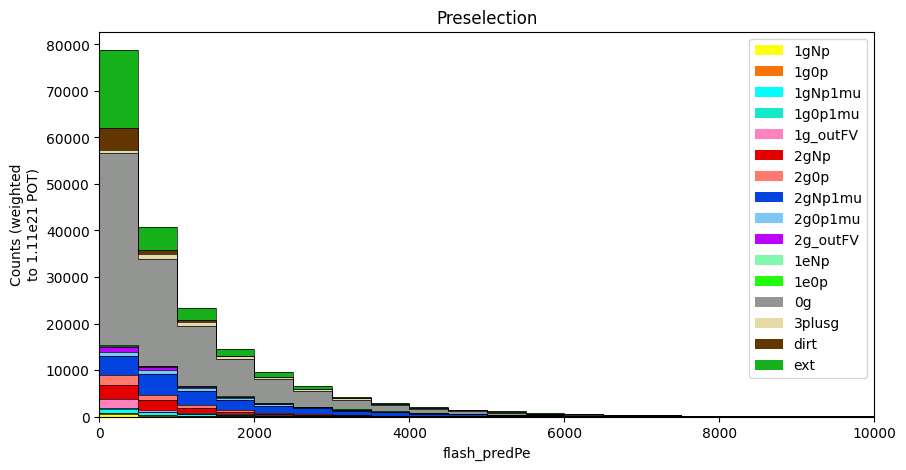

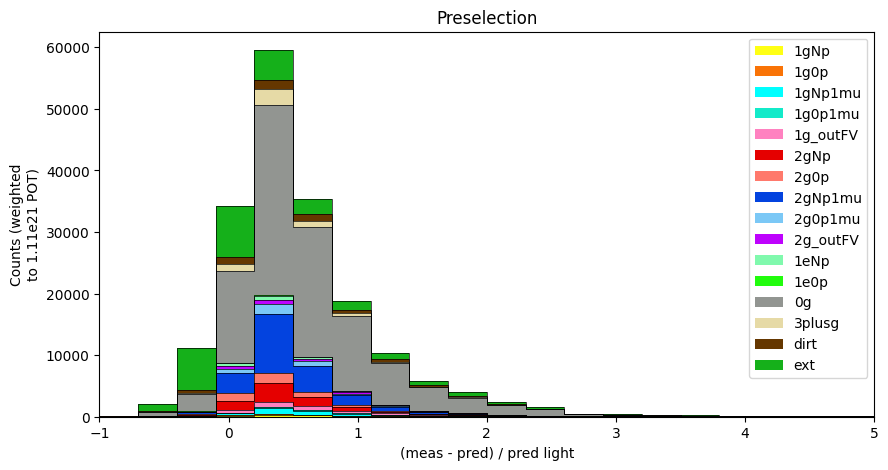

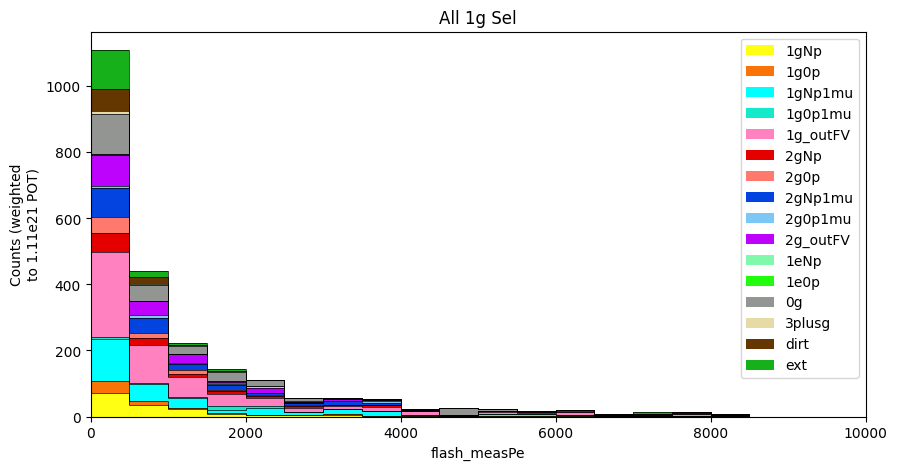

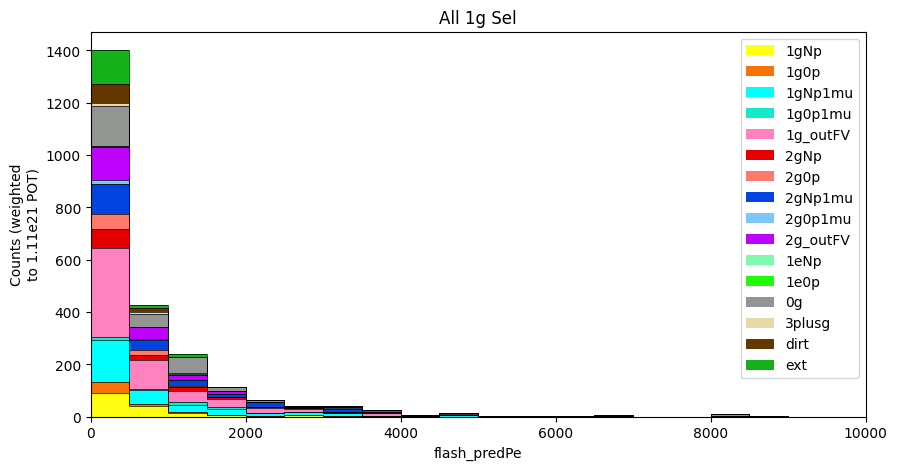

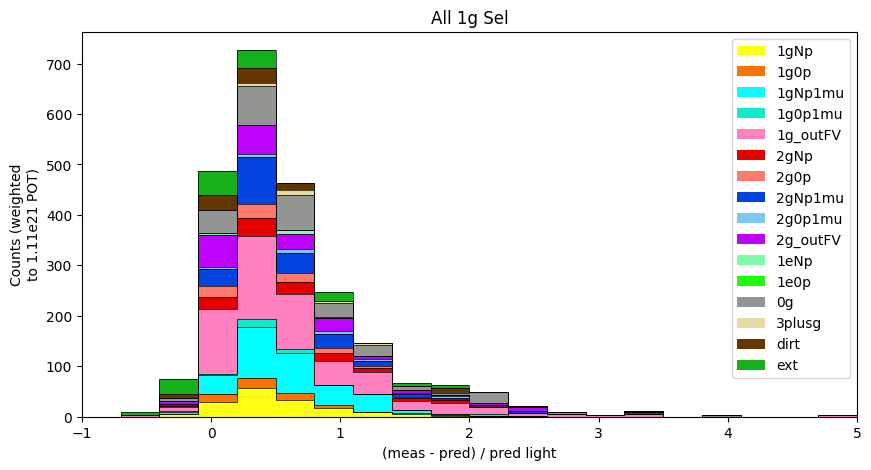

In [12]:
# TODO: Add more detailed PMT-by-PMT information, see https://github.com/kpulido444/REU_uboone_photon_rejection
# Could require SUPRPRISE files with newer WC PMT info

for breakdown_type in ["topological"]:
    if breakdown_type == "topological":
        breakdown_labels = topological_category_labels
        breakdown_colors = topological_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"topological_signal_category == '{label}'")
    elif breakdown_type == "physics":
        breakdown_labels = physics_category_labels
        breakdown_colors = physics_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"physics_signal_category == '{label}'")
    elif breakdown_type == "filetype":
        breakdown_labels = filetype_category_labels
        breakdown_colors = filetype_category_colors
        breakdown_queries = []
        for label in breakdown_labels:
            breakdown_queries.append(f"filetype == '{label}'")
    else:
        raise ValueError("Invalid breakdown type")
    
    for sel_type in ["presel", "all_1g"]:
        if sel_type == "presel":
            sel_df = presel_merged_df
        elif sel_type == "all_1g":
            sel_df = all_1g_sel_df


        plt.figure(figsize=(10, 5))
        bins = np.linspace(0, 10000, 21)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        multi_bin_centers = [bin_centers] * len(breakdown_labels)
        outline_colors = ["k"] * len(breakdown_labels)
        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            counts.append(np.histogram(curr_df["wc_flash_measPe"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])
        plt.hist(multi_bin_centers, weights=counts, bins=bins, color=breakdown_colors, stacked=True, label=breakdown_labels)
        plt.hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)
        plt.xlabel("flash_measPe")
        plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
        plt.xlim(bins[0], bins[-1])
        plt.legend(loc="upper right")
        if sel_type == "presel":
            plt.title(f"Preselection")
        else:
            plt.title(f"All 1g Sel")
        plt.show()

        plt.figure(figsize=(10, 5))
        bins = np.linspace(0, 10000, 21)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        multi_bin_centers = [bin_centers] * len(breakdown_labels)
        outline_colors = ["k"] * len(breakdown_labels)
        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            counts.append(np.histogram(curr_df["wc_flash_predPe"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])
        plt.hist(multi_bin_centers, weights=counts, bins=bins, color=breakdown_colors, stacked=True, label=breakdown_labels)
        plt.hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)
        plt.xlabel("flash_predPe")
        plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
        plt.xlim(bins[0], bins[-1])
        plt.legend(loc="upper right")
        if sel_type == "presel":
            plt.title(f"Preselection")
        else:
            plt.title(f"All 1g Sel")
        plt.show()

        plt.figure(figsize=(10, 5))
        bins = np.linspace(-1, 5, 21)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        multi_bin_centers = [bin_centers] * len(breakdown_labels)
        outline_colors = ["k"] * len(breakdown_labels)
        counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            ratio = (curr_df["wc_flash_measPe"].to_numpy() - curr_df["wc_flash_predPe"].to_numpy()) / curr_df["wc_flash_predPe"].to_numpy()
            counts.append(np.histogram(ratio, weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])
        plt.hist(multi_bin_centers, weights=counts, bins=bins, color=breakdown_colors, stacked=True, label=breakdown_labels)
        plt.hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)
        plt.xlabel("(meas - pred) / pred light")
        plt.ylabel("Counts (weighted\nto 1.11e21 POT)")
        plt.xlim(bins[0], bins[-1])
        plt.legend(loc="upper right")
        if sel_type == "presel":
            plt.title(f"Preselection")
        else:
            plt.title(f"All 1g Sel")
        plt.show()


## Out-TPC CRT Veto

In [13]:
# TODO: Look at CRT information, and if we can identify in-time out-TPC activity associated with an event
# (even if there's no clean CRT track indicating a through-going cosmic muon)


# Out-TPC Geometric BDT

In [14]:
# TODO: Look at just shower position and direction, use that to separate in-FV vs out-FV reco-1g events


## Spacepoint SSV

In [15]:
# TODO: https://github.com/leehagaman/spacepoint_ssv
# Will require processing ntuples with all cosmic spacepoints turned on
